In [1]:
!pip install opendatasets --q
import opendatasets as od

od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shubhamjangid2604
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:16<00:00, 146MB/s]


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from torchvision import models
import torchvision.transforms.functional as TF
from torch.utils.data import ConcatDataset, random_split

device="cuda" if torch.cuda.is_available()  else "cpu"
device

'cuda'

In [9]:
def get_dataset(dataset):
    images=[]
    labels=[]
    for label in os.listdir(rf"/content/chest-xray-pneumonia/chest_xray/{dataset}"):
        for image in os.listdir(rf"/content/chest-xray-pneumonia/chest_xray/{dataset}/{label}"):
            images.append(os.path.join(rf"/content/chest-xray-pneumonia/chest_xray/{dataset}/{label}",image))
            labels.append(label)

    return images,labels


train_images,train_labels=get_dataset("train")
val_images,val_labels=get_dataset("val")
test_images,test_labels=get_dataset("test")

labels=sorted(set(train_labels))
label_to_idx={"NORMAL":0,"PNEUMONIA":1}
idx_to_label={0:"NORMAL",1:"PNEUMONIA"}

print(len(train_images),len(val_images),len(test_images))

5216 16 624


In [10]:
def get_min(images):
    min_w=None
    min_h=None
    for img in images:
        w,h=Image.open(img).size
        if(min_w is None):
            min_w=w
            min_h=h
        else:
            min_w=min(w,min_w)
            min_h=min(h,min_h)

    return min_w,min_h




def get_max(images):
    max_w=None
    max_h=None
    for img in images:
        w,h=Image.open(img).size
        if(max_w is None):
            max_w=w
            max_h=h
        else:
            max_w=max(w,max_w)
            max_h=max(h,max_h)

    return max_w,max_h

max_w,max_h=get_max(train_images)
min_w,min_h=get_min(train_images)


In [11]:

class PadToSquare:
    def __init__(self,target):
        self.target=target

    def __call__(self,img:Image.Image):

        w,h=img.size

        if(w==0 or h==0):
            print(f"no width or height of image invalid image")

        scale=self.target/max(w,h)

        new_w=int(round(w*scale))
        new_h=int(round(h*scale))

        img = img.resize((new_w, new_h), resample=Image.BICUBIC)
        pad_w=self.target-new_w
        pad_h=self.target-new_h

        pad_left=pad_w//2
        pad_top=pad_h//2

        pad_right=pad_w-pad_left
        pad_bottom=pad_h-pad_top

        return TF.pad(img, padding=(pad_left, pad_top, pad_right, pad_bottom), fill=0)  # black pad



In [12]:
TARGET_512 = 512
TARGET_224 = 224

# If you want 1-channel tensors (suitable for custom models)

transform_512_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ensure single channel
    PadToSquare(TARGET_512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


transform_224_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    PadToSquare(TARGET_224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


# If you want 3 channels (for ImageNet pretrained models)
transform_512_rgb = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # replicate to 3 channels
    PadToSquare(TARGET_512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


transform_224_rgb = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    PadToSquare(TARGET_224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])



In [26]:
class pnuemoniadata(Dataset):
    def __init__(self,images,labels,label_to_idx,transform):
        super().__init__()

        self.images=images
        self.labels=labels
        self.label_to_idx=label_to_idx
        self.transform=transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image=self.images[idx]
        label=self.labels[idx]

        image=Image.open(image)
        image=self.transform(image)
        label=torch.tensor(self.label_to_idx[label],dtype=torch.long)

        return image,label


train_dataset=pnuemoniadata(train_images,train_labels,label_to_idx,transform_224_rgb)

val_dataset=pnuemoniadata(val_images,val_labels,label_to_idx,transform_224_rgb)
test_dataset=pnuemoniadata(test_images,test_labels,label_to_idx,transform_224_rgb)

"""
we have very small val dataset so we merged the valdataset and test dataset and then again split it
"""



val_dataset=ConcatDataset([val_dataset,test_dataset])

n_total=len(val_dataset)
n_val=int(0.2*n_total)
n_test=n_total-n_val

val_dataset,test_dataset=random_split(val_dataset,[n_val,n_test])





train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)


print(len(train_loader),len(val_loader),len(test_loader))

326 4 16


In [27]:
# loading the densenet pretrained model
model=models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

class ClassifierHead(nn.Module):
    def __init__(self,num_features:int,num_classes:int,dropout:float=0.2):
        super().__init__()
        self.fc_1=nn.Linear(num_features,256)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout(dropout)
        self.f_final=nn.Linear(256,num_classes)


    def forward(self,x):
        x=self.fc_1(x)
        x=self.dropout(self.relu(x))

        x=self.f_final(x)
        return x


num_features=model.classifier.in_features
model.classifier=ClassifierHead(num_features,2,0.2)

for params in model.features.parameters():
    params.requires_grad=False


def count_trainable_params(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

trainable_params,total_params=count_trainable_params(model)


In [28]:

criterion=nn.CrossEntropyLoss(reduction="mean")

optimizer=torch.optim.AdamW(model.parameters(),lr=3e-4)



num_epochs=6



def model_train(model,device,train_loader,val_loader,num_epochs,optimizer,criterion,grad_clip=None):
    model=model.to(device)
    train_losses=[]
    val_losses=[]
    train_epoch_losses=[]
    val_epoch_losses=[]


    for epoch in range(num_epochs):
        print(f"epoch: {epoch+1}/{num_epochs}")
        model.train()
        running_val_loss=0
        running_train_loss=0
        for train_step, batch in enumerate(train_loader):
            image,label=batch
            image=image.to(device)
            label=label.to(device)

            optimizer.zero_grad()

            logits=model(image)
            loss=criterion(logits,label)

            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            running_train_loss += loss.item()
            if(train_step%65==0):
                train_losses.append(loss.item())
                if(train_step%130==0):
                    print(f"train_loss as step {train_step} : {loss.item()}")



        train_avg_loss=running_train_loss/len(train_loader)
        train_epoch_losses.append(train_avg_loss)
        print(f"train_loss for epoch {epoch}:{train_avg_loss}")
        model.eval()

        with torch.no_grad():
            for val_step,batch in enumerate(val_loader):
                image,label=batch
                image=image.to(device)
                label=label.to(device)

                logits=model(image)
                loss=criterion(logits,label)

                running_val_loss +=loss.item()
                val_losses.append(loss.item())

                if(val_step%2==0):
                    print(f"val_loss as step {val_step} : {loss.item()}")
            val_avg_loss= running_val_loss/len(val_loader)
            val_epoch_losses.append(val_avg_loss)

            print(f"val loss for epoch {epoch} : {val_avg_loss}")
    return {
        "train_step_losses": train_losses,
        "train_epoch_losses": train_epoch_losses,
        "val_step_losses": val_losses,
        "val_epoch_losses": val_epoch_losses
    }





In [29]:
results=model_train(model,device,train_loader,val_loader,num_epochs,optimizer,criterion)

epoch: 1/6
train_loss as step 0 : 0.6828608512878418
train_loss as step 130 : 0.04680580273270607
train_loss as step 260 : 0.4418962597846985
train_loss for epoch 0:0.22270769907584403
val_loss as step 0 : 0.3482205867767334
val_loss as step 2 : 0.21685892343521118
val loss for epoch 0 : 0.2919429764151573
epoch: 2/6
train_loss as step 0 : 0.1717495322227478
train_loss as step 130 : 0.10712974518537521
train_loss as step 260 : 0.037280671298503876
train_loss for epoch 1:0.15596114726668578
val_loss as step 0 : 0.8903123140335083
val_loss as step 2 : 0.7847855091094971
val loss for epoch 1 : 0.834296703338623
epoch: 3/6
train_loss as step 0 : 0.06967297196388245
train_loss as step 130 : 0.18805992603302002
train_loss as step 260 : 0.10503032803535461
train_loss for epoch 2:0.15645148134876066
val_loss as step 0 : 0.4036465287208557
val_loss as step 2 : 0.2989480495452881
val loss for epoch 2 : 0.34429988265037537
epoch: 4/6
train_loss as step 0 : 0.08085282891988754
train_loss as step 1

In [30]:
model=model.to(device)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")






Test Accuracy: 0.8242


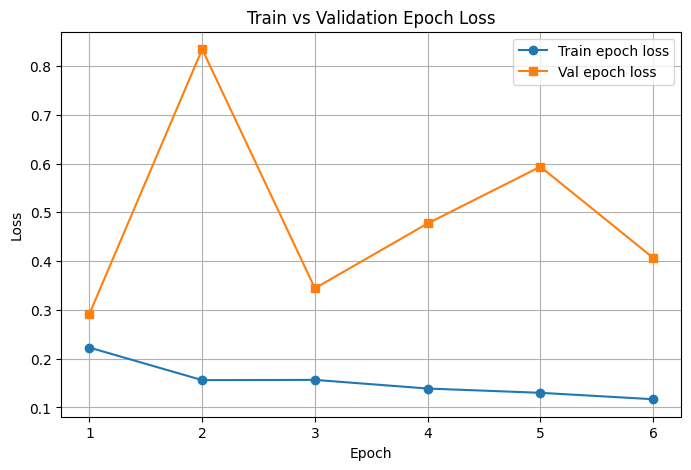

In [35]:
import matplotlib.pyplot as plt

train_epoch = results['train_epoch_losses']  # 6 values
val_epoch   = results['val_epoch_losses']    # 6 values
epochs = range(1, len(train_epoch)+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_epoch, marker='o', label='Train epoch loss')
plt.plot(epochs, val_epoch, marker='s', label='Val epoch loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Epoch Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()


